# Why does a topological layering emerge in neural networks?
_An example with XOR_

## Libraries & Setup

In [1]:
import sys
sys.path.append('../')

In [2]:
from tqdm import tqdm
from math import sin, pi
from funcs import topk_mask

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [3]:
from layers import CompleteLayer
from inits import Size, Like
from inits import (
    RandomNormal,
    RandomUniform,
    Ones,
    Zeros,
    Triu
)
from pruning import PruneEnsemble
from pruning import (
    NoPrune,
    RandomPrune,
    TopKPrune,
    DynamicTopK,
    ThresholdPrune,
    TriuPrune,
    TriuDamp,
    DynamicTriuDamp
)
import losses
from training import train
from evals import LineVisualiser, WeightVisualiser, DirectionalityVisualiser
import experiments

In [4]:
if torch.cuda.is_available():
    try:
        _ = torch.tensor([0], device='cuda')
        device = torch.device('cuda')
    except:
        device = torch.device('cpu')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: cpu


/home/yiding/micromamba/envs/nsarc/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Generate XOR Data

In [5]:
x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32).to(device)
y = torch.unsqueeze(torch.logical_xor(x[:, 0], x[:, 1]), 1).to(torch.float32).to(device)
dataloader = DataLoader(TensorDataset(x, y), batch_size=4, shuffle=True)

## Simple Baseline

100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


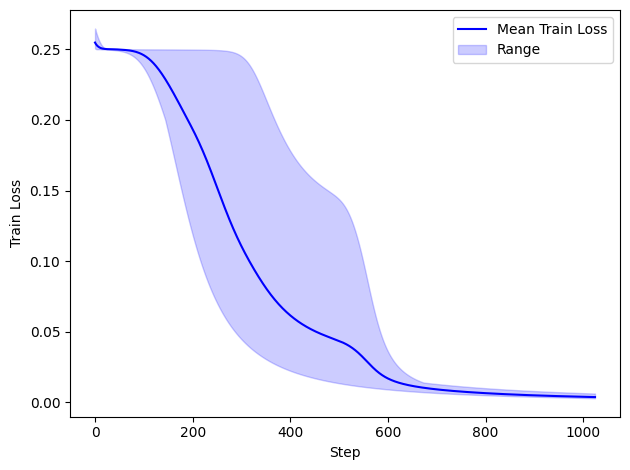

In [6]:
def baseline_setup():
    baseline = nn.Sequential(
        nn.Linear(2, 2, bias=True),
        nn.Sigmoid(),
        nn.Linear(2, 1, bias=True),
        nn.Sigmoid()
    ).to(device)
    criterion = losses.MSELoss()
    optim = torch.optim.Adam(baseline.parameters(), lr=0.01)
    return {
        'model': baseline,
        'train_criterion': criterion,
        'optimiser': optim
    }

visualisers = experiments.run(
    tries=5,
    seed=1,
    setup_fn=baseline_setup,
    visualisers={
        'line': LineVisualiser(
            lambda r: r['train_losses'],
            xlabel='Step',
            ylabel='Train Loss',
            only_values=True
        )
    },
    n_epochs=10000,
    train_dataloader=dataloader,
    early_stop=3e-3
)

## Complete Network

100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

Directionality: 0.767 $\pm$ 0.130


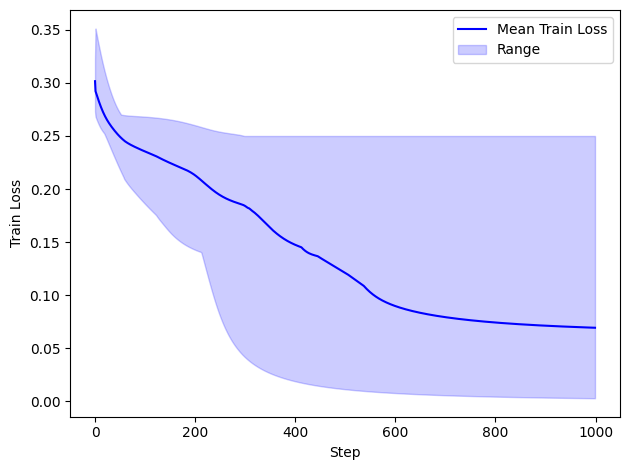

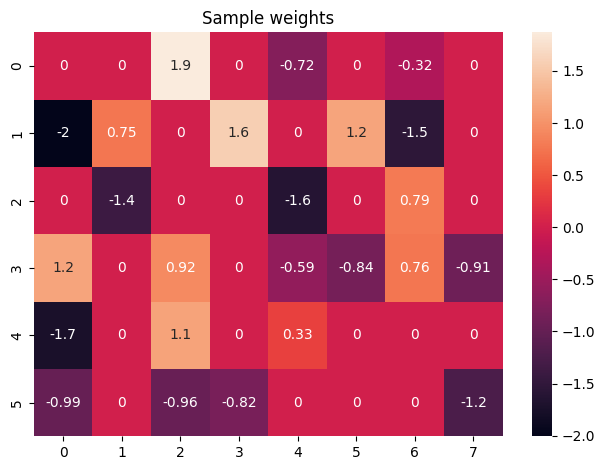

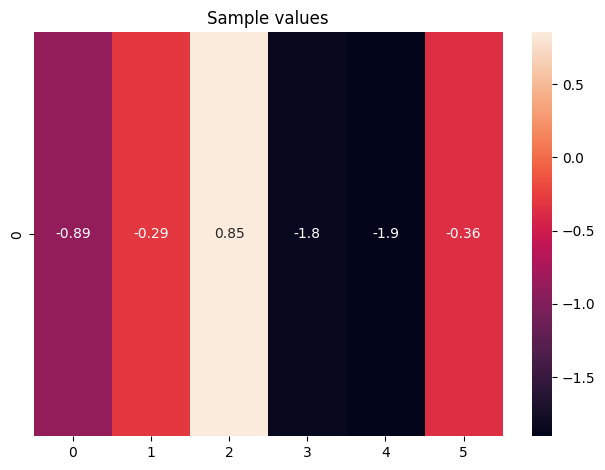

In [17]:
def setup():
    complete = CompleteLayer(
        input_size=2,
        hidden_size=5,
        output_size=1,
        values_init=(RandomNormal, True),  # try initialising differently
        weights_init=(RandomNormal, True),
        bias_init=(Zeros, False),
        scores_init=(Ones, False),
        scores_k=1.,
        activation=F.sigmoid,
        use_bias=False
    ).to(device)
    optim = torch.optim.Adam(complete.parameters(), lr=0.01)
    return {
        'model': complete,
        'optimiser': optim
    }

visualisers, result = experiments.run(
    its=3,
    pruner=PruneEnsemble({
        'values': NoPrune(),
        'weights': TopKPrune(k=0.5),
    }),
    visualisers={
        'directionality': DirectionalityVisualiser(
            lambda r: r['model'].weights,
            name = 'weights',
            graphs=False
        ),
        'train': LineVisualiser(
            lambda r: r['train_losses'],
            xlabel='Step',
            ylabel='Train Loss',
            only_values=True
        ),
        # LineVisualiser(
        #     lambda r: (r['val_steps'], r['val_losses']),
        #     xlabel='Step',
        #     ylabel='Validation Loss'
        # ),
        'weights': WeightVisualiser(
            lambda r: r['model'].weights,
            name = 'weights',
            show = ['sample']  # ['mean', 'std', 'abs-mean', 'sample']
        ),
        'values': WeightVisualiser(
            lambda r: r['model'].values,
            name = 'values',
            show = ['sample']
        ),
    },
    seed=20,    # 10
    tries=5,
    n_epochs=1000,
    setup_fn=setup,
    train_dataloader=dataloader,
    train_criterion=losses.MSELoss(),
    # val_dataloader=dataloader,
    # val_criterion=losses.MSELoss(),
    early_stop=0
)

Directionality: 0.870


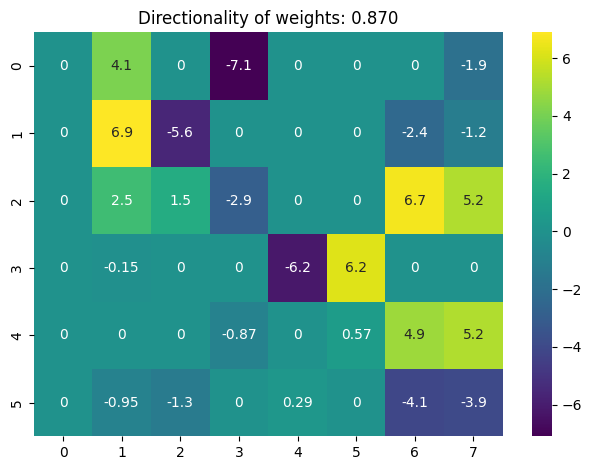

In [25]:
from utils import permute, brute_force_directionality

sample = visualisers['weights'].all_weights[1]
square = sample[:, :-2]
directionality, perm = brute_force_directionality(square, 2)
print(f'Directionality: {directionality:.3f}')

sns.heatmap(permute(sample, perm, perm+[6, 7]), annot=True, cmap='viridis')
plt.title(f'Directionality of weights: {directionality:.3f}')
plt.tight_layout()
plt.savefig('../media/weights/xor.pdf')
plt.show()

# UI-Plot

In [13]:
its = list(range(1, 11))
units = list(range(1, 10, 2))

ui_means = np.zeros((len(units), len(its)))
ui_stds = np.zeros((len(units), len(its)))

pbar = tqdm(total=len(units) * len(its))
for u_idx, u in enumerate(units):
    for i_idx, i in enumerate(its):

        def _setup():
            complete = CompleteLayer(
                input_size=2,
                hidden_size=u,
                output_size=1,
                values_init=(RandomNormal, True),  # try initialising differently
                weights_init=(RandomNormal, True),
                bias_init=(Zeros, False),
                scores_init=(Ones, False),
                scores_k=1.,
                activation=F.sigmoid,
                use_bias=False
            ).to(device)
            optim = torch.optim.Adam(complete.parameters(), lr=0.01)
            return {
                'model': complete,
                'optimiser': optim
            }

        visualisers, result = experiments.run(
            its=i,
            pruner=PruneEnsemble({
                'values': NoPrune(),
                'weights': DynamicTopK(k=0.5),
            }),
            visualisers={
                'directionality': DirectionalityVisualiser(
                    lambda r: r['model'].weights,
                    name = 'weights',
                    graphs=False
                )
            },
            seed=20,    # 10
            tries=5,
            n_epochs=1000,
            setup_fn=_setup,
            train_dataloader=dataloader,
            train_criterion=losses.MSELoss(),
            early_stop=0
        )

        ui_means[u_idx, i_idx] = visualisers['directionality'].mean_dir
        ui_stds[u_idx, i_idx] = visualisers['directionality'].std_dir
        pbar.update(1)

100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Directionality: 0.717 $\pm$ 0.234


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Directionality: 1.000 $\pm$ 0.000


100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Directionality: 0.728 $\pm$ 0.345


100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


Directionality: 0.909 $\pm$ 0.182


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


Directionality: 0.894 $\pm$ 0.213


100%|██████████| 5/5 [00:12<00:00,  2.41s/it]


Directionality: 0.889 $\pm$ 0.221


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


Directionality: 0.887 $\pm$ 0.226


100%|██████████| 5/5 [00:16<00:00,  3.33s/it]


Directionality: 0.884 $\pm$ 0.231


100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


Directionality: 0.884 $\pm$ 0.232


100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


Directionality: 0.885 $\pm$ 0.230


100%|██████████| 5/5 [00:10<00:00,  2.00s/it]


Directionality: 0.614 $\pm$ 0.134


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


Directionality: 0.885 $\pm$ 0.088


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Directionality: 0.865 $\pm$ 0.166


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Directionality: 0.805 $\pm$ 0.104


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


Directionality: 0.814 $\pm$ 0.118


100%|██████████| 5/5 [00:14<00:00,  3.00s/it]


Directionality: 0.822 $\pm$ 0.133


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


Directionality: 0.777 $\pm$ 0.106


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


Directionality: 0.738 $\pm$ 0.151


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


Directionality: 0.776 $\pm$ 0.151


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


Directionality: 0.790 $\pm$ 0.107


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Directionality: 0.644 $\pm$ 0.088


100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Directionality: 0.843 $\pm$ 0.085


100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


Directionality: 0.715 $\pm$ 0.076


100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Directionality: 0.794 $\pm$ 0.109


100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


Directionality: 0.794 $\pm$ 0.079


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


Directionality: 0.734 $\pm$ 0.095


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


Directionality: 0.763 $\pm$ 0.076


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Directionality: 0.775 $\pm$ 0.056


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Directionality: 0.781 $\pm$ 0.062


100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


Directionality: 0.747 $\pm$ 0.067


100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


Directionality: 0.639 $\pm$ 0.062


100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Directionality: 0.814 $\pm$ 0.023


100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


Directionality: 0.724 $\pm$ 0.075


100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


Directionality: 0.788 $\pm$ 0.050


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Directionality: 0.715 $\pm$ 0.039


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Directionality: 0.742 $\pm$ 0.035


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Directionality: 0.730 $\pm$ 0.022


100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Directionality: 0.714 $\pm$ 0.035


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Directionality: 0.729 $\pm$ 0.051


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Directionality: 0.747 $\pm$ 0.050


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Directionality: 0.696 $\pm$ 0.043


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Directionality: 0.807 $\pm$ 0.020


100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Directionality: 0.768 $\pm$ 0.024


100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Directionality: 0.741 $\pm$ 0.063


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


Directionality: 0.740 $\pm$ 0.035


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Directionality: 0.729 $\pm$ 0.039


100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


Directionality: 0.711 $\pm$ 0.033


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Directionality: 0.713 $\pm$ 0.026


100%|██████████| 5/5 [00:09<00:00,  1.80s/it]


Directionality: 0.716 $\pm$ 0.036


100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


Directionality: 0.735 $\pm$ 0.027


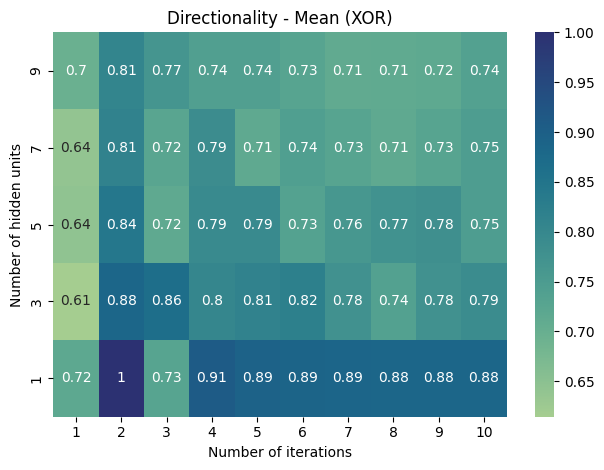

In [14]:
sns.heatmap(
    ui_means[::-1],
    annot=True,
    yticklabels=units[::-1],
    xticklabels=its,
    cmap='crest'
)

plt.title('Directionality - Mean (XOR)')
plt.xlabel('Number of iterations')
plt.ylabel('Number of hidden units')
plt.tight_layout()
plt.savefig('../media/ui/xor-mean.pdf')
plt.show()

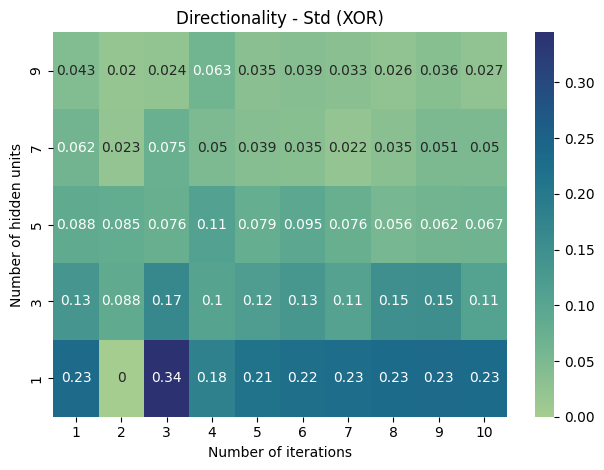

In [15]:
sns.heatmap(
    ui_stds[::-1],
    annot=True,
    yticklabels=units[::-1],
    xticklabels=its,
    cmap='crest'
)

plt.title('Directionality - Std (XOR)')
plt.xlabel('Number of iterations')
plt.ylabel('Number of hidden units')
plt.tight_layout()
plt.savefig('../media/ui/xor-std.pdf')
plt.show()

# VD-Plots

In [11]:
vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

pruners = {
    'Random': (RandomPrune, 'p'),
    'Top-K': (TopKPrune, 'k'),
    'Dyn. Top-K': (DynamicTopK, 'k'),
    'Triu-damp': (TriuDamp, 'f'),
    'Dyn. Triu-damp': (DynamicTriuDamp, 'f')
}

vd_means = {
    p: []
    for p in pruners
}

vd_stds = {
    p: []
    for p in pruners
}

vd_maxs = {
    p: []
    for p in pruners
}

vd_mins = {
    p: []
    for p in pruners
}

pbar = tqdm(total=len(vals) * len(pruners))
for pn in pruners:
    for v_idx, v in enumerate(vals):

        def _setup():
            complete = CompleteLayer(
                input_size=2,
                hidden_size=5,
                output_size=1,
                values_init=(RandomNormal, True),  # try initialising differently
                weights_init=(RandomNormal, True),
                bias_init=(Zeros, False),
                scores_init=(Ones, False),
                scores_k=1.,
                activation=F.sigmoid,
                use_bias=False
            ).to(device)
            optim = torch.optim.Adam(complete.parameters(), lr=0.01)
            return {
                'model': complete,
                'optimiser': optim
            }

        visualisers, result = experiments.run(
            its=3,
            pruner=PruneEnsemble({
                'values': NoPrune(),
                'weights': pruners[pn][0](**{pruners[pn][1]: v}),
            }),
            visualisers={
                'directionality': DirectionalityVisualiser(
                    lambda r: r['model'].weights,
                    name = 'weights',
                    graphs=False
                )
            },
            seed=20,    # 10
            tries=5,
            n_epochs=1000,
            setup_fn=_setup,
            train_dataloader=dataloader,
            train_criterion=losses.MSELoss(),
            early_stop=0
        )

        vd_means[pn].append(visualisers['directionality'].mean_dir)
        vd_stds[pn].append(visualisers['directionality'].std_dir)
        vd_maxs[pn].append(visualisers['directionality'].max_dir)
        vd_mins[pn].append(visualisers['directionality'].min_dir)
        pbar.update(1)

  2%|▏         | 1/45 [00:10<07:33, 10.31s/it]

Directionality: 0.749 $\pm$ 0.021


  4%|▍         | 2/45 [00:21<07:36, 10.60s/it]

Directionality: 0.681 $\pm$ 0.043


  7%|▋         | 3/45 [00:31<07:18, 10.45s/it]

Directionality: 0.714 $\pm$ 0.055


  9%|▉         | 4/45 [00:42<07:11, 10.53s/it]

Directionality: 0.666 $\pm$ 0.031


 11%|█         | 5/45 [00:54<07:23, 11.10s/it]

Directionality: 0.807 $\pm$ 0.070


 13%|█▎        | 6/45 [01:05<07:16, 11.20s/it]

Directionality: 0.814 $\pm$ 0.073


 16%|█▌        | 7/45 [01:17<07:16, 11.49s/it]

Directionality: 0.870 $\pm$ 0.043


 18%|█▊        | 8/45 [01:28<06:55, 11.24s/it]

Directionality: 0.798 $\pm$ 0.093


 20%|██        | 9/45 [01:37<06:26, 10.73s/it]

Directionality: 0.649 $\pm$ 0.149


 22%|██▏       | 10/45 [01:47<06:04, 10.40s/it]

Directionality: 0.725 $\pm$ 0.337


 24%|██▍       | 11/45 [01:57<05:52, 10.35s/it]

Directionality: 0.585 $\pm$ 0.191


 27%|██▋       | 12/45 [02:08<05:48, 10.57s/it]

Directionality: 0.691 $\pm$ 0.102


 29%|██▉       | 13/45 [02:20<05:51, 10.97s/it]

Directionality: 0.711 $\pm$ 0.109


 31%|███       | 14/45 [02:31<05:33, 10.75s/it]

Directionality: 0.767 $\pm$ 0.130


 33%|███▎      | 15/45 [02:43<05:37, 11.25s/it]

Directionality: 0.701 $\pm$ 0.094


 36%|███▌      | 16/45 [02:53<05:16, 10.93s/it]

Directionality: 0.740 $\pm$ 0.055


 38%|███▊      | 17/45 [03:03<04:54, 10.51s/it]

Directionality: 0.737 $\pm$ 0.058


 40%|████      | 18/45 [03:13<04:44, 10.54s/it]

Directionality: 0.656 $\pm$ 0.075


 42%|████▏     | 19/45 [03:23<04:25, 10.20s/it]

Directionality: 0.619 $\pm$ 0.373


 44%|████▍     | 20/45 [03:33<04:14, 10.18s/it]

Directionality: 0.742 $\pm$ 0.147


 47%|████▋     | 21/45 [03:42<03:59,  9.97s/it]

Directionality: 0.676 $\pm$ 0.093


 49%|████▉     | 22/45 [03:53<03:53, 10.14s/it]

Directionality: 0.716 $\pm$ 0.089


 51%|█████     | 23/45 [04:04<03:50, 10.45s/it]

Directionality: 0.715 $\pm$ 0.076


 53%|█████▎    | 24/45 [04:15<03:39, 10.45s/it]

Directionality: 0.698 $\pm$ 0.062


 56%|█████▌    | 25/45 [04:26<03:33, 10.68s/it]

Directionality: 0.675 $\pm$ 0.038


 58%|█████▊    | 26/45 [04:33<03:01,  9.55s/it]

Directionality: 0.661 $\pm$ 0.043


 60%|██████    | 27/45 [04:39<02:36,  8.70s/it]

Directionality: 0.654 $\pm$ 0.040


 62%|██████▏   | 28/45 [04:46<02:16,  8.02s/it]

Directionality: 0.998 $\pm$ 0.001


 64%|██████▍   | 29/45 [04:53<02:02,  7.65s/it]

Directionality: 0.999 $\pm$ 0.001


 67%|██████▋   | 30/45 [05:00<01:52,  7.48s/it]

Directionality: 1.000 $\pm$ 0.000


 69%|██████▉   | 31/45 [05:05<01:36,  6.91s/it]

Directionality: 1.000 $\pm$ 0.000


 71%|███████   | 32/45 [05:12<01:29,  6.87s/it]

Directionality: 1.000 $\pm$ 0.000


 73%|███████▎  | 33/45 [05:18<01:19,  6.64s/it]

Directionality: 1.000 $\pm$ 0.000


 76%|███████▌  | 34/45 [05:25<01:14,  6.79s/it]

Directionality: 1.000 $\pm$ 0.000


 78%|███████▊  | 35/45 [05:31<01:03,  6.37s/it]

Directionality: 1.000 $\pm$ 0.000


 80%|████████  | 36/45 [05:36<00:55,  6.12s/it]

Directionality: 1.000 $\pm$ 0.000


 82%|████████▏ | 37/45 [05:42<00:47,  5.99s/it]

Directionality: 0.996 $\pm$ 0.002


 84%|████████▍ | 38/45 [05:49<00:43,  6.19s/it]

Directionality: 0.999 $\pm$ 0.001


 87%|████████▋ | 39/45 [05:55<00:37,  6.25s/it]

Directionality: 0.999 $\pm$ 0.000


 89%|████████▉ | 40/45 [06:02<00:31,  6.38s/it]

Directionality: 1.000 $\pm$ 0.000


 91%|█████████ | 41/45 [06:08<00:25,  6.38s/it]

Directionality: 1.000 $\pm$ 0.000


 93%|█████████▎| 42/45 [06:15<00:19,  6.51s/it]

Directionality: 1.000 $\pm$ 0.000


 96%|█████████▌| 43/45 [06:20<00:12,  6.26s/it]

Directionality: 1.000 $\pm$ 0.000


 98%|█████████▊| 44/45 [06:26<00:06,  6.06s/it]

Directionality: 1.000 $\pm$ 0.000


100%|██████████| 45/45 [06:32<00:00,  5.90s/it]

Directionality: 1.000 $\pm$ 0.000


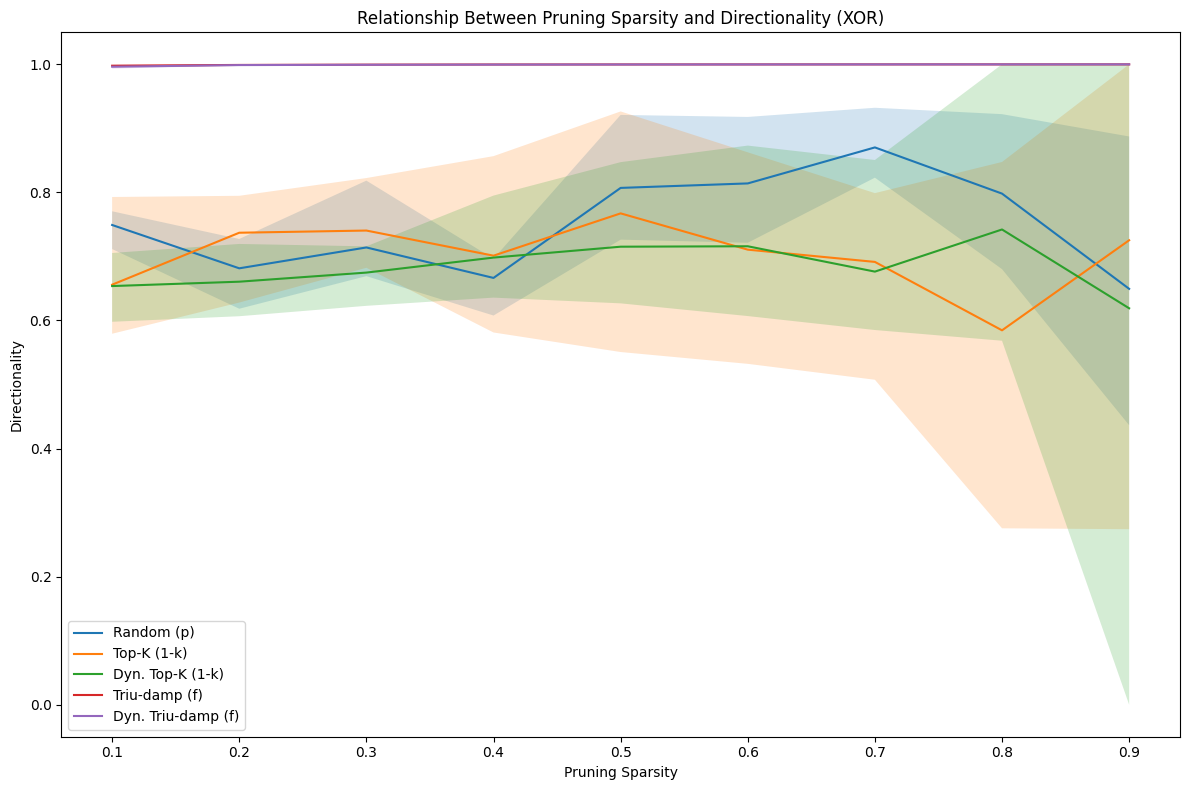

In [12]:
plt.figure(figsize=(12, 8))

for pn in pruners:
    if 'Top-K' in pn:
        plt.plot(vals[::-1], vd_means[pn], label=pn + f' (1-{pruners[pn][1]})')
        plt.fill_between(vals[::-1], vd_maxs[pn], vd_mins[pn], alpha=0.2)
    else:
        plt.plot(vals, vd_means[pn], label=pn + f' ({pruners[pn][1]})')
        plt.fill_between(vals, vd_maxs[pn], vd_mins[pn], alpha=0.2)

plt.legend()
plt.xlabel('Pruning Sparsity')
plt.ylabel('Directionality')
plt.title('Relationship Between Pruning Sparsity and Directionality (XOR)')
plt.tight_layout()
plt.savefig('../media/vd/xor.pdf')
plt.show()